In [1]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from itertools import product
from scipy.signal import find_peaks
import random
import math
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
from datetime import datetime

In [2]:
def clean_gpu_memory():
    # Releases all unused cached memory from GPU and collects inter-process communication (IPC) handles.
    # Helps prevent memory fragmentation and makes more memory available for future operations.
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()


In [3]:
# StockLSTM: Defines a custom LSTM model architecture for predicting stock prices.
# - Takes in technical + sentiment features.
# - Uses 3 LSTM layers followed by fully connected layers.
# - Outputs a single predicted stock price (Close).


In [4]:
class StockLSTM(nn.Module):
    """
    A simple LSTM model for stock price prediction.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.4)

        # Define fully connected layers after LSTM
        self.fc_layers = nn.Sequential(
        nn.Linear(hidden_size, 64),
        nn.ReLU(),
        nn.Dropout(0.3),  # Dropout after first hidden layer
    
        nn.Linear(64, 16),
        nn.ReLU(),
        nn.Dropout(0.3),  # Dropout after second hidden layer
    
        nn.Linear(16, output_size)
        )


    def forward(self, x):
        # Initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc_layers(out[:, -1, :])  # Take the last timestep
        return out

In [5]:
# compute_technical_indicators(data):
# Computes 25+ technical indicators including:
# - MACD, RSI, ATR, MFI, Bollinger Bands
# - VWAP, CMF, Parabolic SAR, Fibonacci Levels
# - Stochastic Oscillator, ROC, ADX, etc.
# Adds all new columns to the DataFrame.


In [6]:
def compute_technical_indicators(data):
    """
    Computes various technical indicators such as MACD, RSI, ATR, MFI, Bollinger Bands, etc.
    Returns the modified DataFrame with new columns.
    """
    # Exponential Moving Averages for MACD
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    
    # RSI
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    window_length = 14
    avg_gain = gain.rolling(window=window_length, min_periods=window_length).mean()
    avg_loss = loss.rolling(window=window_length, min_periods=window_length).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100.0 - (100.0 / (1.0 + rs))
    data['RSI'].fillna(0, inplace=True)

    # ATR
    data['HL'] = data['High'] - data['Low']
    data['HC'] = abs(data['High'] - data['Close'].shift(1))
    data['LC'] = abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['HL', 'HC', 'LC']].max(axis=1)
    atr_window = 14
    data['ATR'] = data['TR'].rolling(window=atr_window, min_periods=atr_window).mean()
    data['ATR'].fillna(0, inplace=True)
    
    # MFI
    data['TP'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['RMF'] = data['TP'] * data['Volume']
    data['PMF'] = np.where(data['Close'] > data['Close'].shift(1), data['RMF'], 0)
    data['NMF'] = np.where(data['Close'] < data['Close'].shift(1), data['RMF'], 0)
    mfi_window = 14
    positive_mf = data['PMF'].rolling(window=mfi_window, min_periods=mfi_window).sum()
    negative_mf = data['NMF'].rolling(window=mfi_window, min_periods=mfi_window).sum()
    money_ratio = positive_mf / negative_mf
    data['MFI'] = 100 - 100 / (1 + money_ratio)
    data['MFI'].fillna(0, inplace=True)
    
    # Bollinger Bands
    bb_window = 20
    bb_std = 2
    data['BB_Middle'] = data['Close'].rolling(window=bb_window, min_periods=bb_window).mean()
    data['BB_Std'] = data['Close'].rolling(window=bb_window, min_periods=bb_window).std()
    data['BB_Upper'] = data['BB_Middle'] + (bb_std * data['BB_Std'])
    data['BB_Lower'] = data['BB_Middle'] - (bb_std * data['BB_Std'])
    data[['BB_Middle','BB_Std','BB_Upper','BB_Lower']] = data[['BB_Middle','BB_Std','BB_Upper','BB_Lower']].fillna(method='bfill')
    
    # Stochastic Oscillator
    so_window = 14
    data['SO_Low'] = data['Low'].rolling(window=so_window, min_periods=so_window).min()
    data['SO_High'] = data['High'].rolling(window=so_window, min_periods=so_window).max()
    data['SO_%K'] = ((data['Close'] - data['SO_Low']) / (data['SO_High'] - data['SO_Low'])) * 100
    data['SO_%D'] = data['SO_%K'].rolling(window=3, min_periods=3).mean()
    data['SO_%K'].fillna(0, inplace=True)
    data['SO_%D'].fillna(0, inplace=True)
    
    # ADX
    data['+DM'] = np.where(
        (data['High'] - data['High'].shift(1)) > (data['Low'].shift(1) - data['Low']), 
        np.maximum(data['High'] - data['High'].shift(1), 0), 0
    )
    data['-DM'] = np.where(
        (data['Low'].shift(1) - data['Low']) > (data['High'] - data['High'].shift(1)), 
        np.maximum(data['Low'].shift(1) - data['Low'], 0), 0
    )
    data['TR_Smoothed'] = data['TR'].rolling(window=atr_window, min_periods=atr_window).sum()
    data['+DM_Smoothed'] = data['+DM'].rolling(window=atr_window, min_periods=atr_window).sum()
    data['-DM_Smoothed'] = data['-DM'].rolling(window=atr_window, min_periods=atr_window).sum()
    data['+DI'] = (data['+DM_Smoothed'] / data['TR_Smoothed']) * 100
    data['-DI'] = (data['-DM_Smoothed'] / data['TR_Smoothed']) * 100
    data['DX'] = (np.abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])) * 100
    data['ADX'] = data['DX'].rolling(window=atr_window, min_periods=atr_window).mean()
    data['ADX'].fillna(0, inplace=True)
    
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']
    data['MACD_Histogram'].fillna(0, inplace=True)
    
    # VWAP
    data['Cumulative_TP_Volume'] = (data['Close'] * data['Volume']).cumsum()
    data['Cumulative_Volume'] = data['Volume'].cumsum()
    data['VWAP'] = data['Cumulative_TP_Volume'] / data['Cumulative_Volume']
    data['VWAP'].fillna(0, inplace=True)
    
    # CMF
    cmf_window = 20
    data['MFM'] = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
    data['MFM'].replace([np.inf, -np.inf], 0, inplace=True)
    data['MFM'].fillna(0, inplace=True)
    data['MFV'] = data['MFM'] * data['Volume']
    data['CMF'] = (data['MFV'].rolling(window=cmf_window, min_periods=cmf_window).sum() /
                   data['Volume'].rolling(window=cmf_window, min_periods=cmf_window).sum())
    data['CMF'].fillna(0, inplace=True)
    
    # Fibonacci Levels
    fib_period = 60
    max_close = data['Close'].rolling(window=fib_period, min_periods=fib_period).max()
    min_close = data['Close'].rolling(window=fib_period, min_periods=fib_period).min()
    data['Fib_23.6'] = max_close - (max_close - min_close) * 0.236
    data['Fib_38.2'] = max_close - (max_close - min_close) * 0.382
    data['Fib_50.0'] = max_close - (max_close - min_close) * 0.5
    data['Fib_61.8'] = max_close - (max_close - min_close) * 0.618
    data['Fib_76.4'] = max_close - (max_close - min_close) * 0.764
    fib_levels = ['Fib_23.6','Fib_38.2','Fib_50.0','Fib_61.8','Fib_76.4']
    for level in fib_levels:
        data[level].fillna(method='bfill', inplace=True)
        data[level].fillna(method='ffill', inplace=True)
        data[level].fillna(0, inplace=True)
    
    # ROC
    roc_window = 12
    data['ROC'] = ((data['Close'] - data['Close'].shift(roc_window)) / data['Close'].shift(roc_window)) * 100
    data['ROC'].fillna(0, inplace=True)
    
    # Basic Parabolic SAR (simplified approach)
    psar_step = 0.02
    psar_max = 0.2
    data['PSAR'] = data['Close']  # Initialize with close
    if len(data) > 1:
        long = True
        af = psar_step
        ep = data['High'].iloc[0]
        psar = data['Low'].iloc[0]
        for i in range(1, len(data)):
            prev_psar = psar
            if long:
                psar = prev_psar + af * (ep - prev_psar)
                psar = min(psar, data['Low'].iloc[i-1],
                           data['Low'].iloc[i-2] if i >= 2 else data['Low'].iloc[i-1])
            else:
                psar = prev_psar + af * (ep - prev_psar)
                psar = max(psar, data['High'].iloc[i-1],
                           data['High'].iloc[i-2] if i >= 2 else data['High'].iloc[i-1])
            
            reverse = False
            if long and data['Low'].iloc[i] < psar:
                long = False
                reverse = True
                psar = ep
                ep = data['Low'].iloc[i]
                af = psar_step
            elif not long and data['High'].iloc[i] > psar:
                long = True
                reverse = True
                psar = ep
                ep = data['High'].iloc[i]
                af = psar_step
            
            if not reverse:
                if long and data['High'].iloc[i] > ep:
                    ep = data['High'].iloc[i]
                    af = min(af + psar_step, psar_max)
                elif not long and data['Low'].iloc[i] < ep:
                    ep = data['Low'].iloc[i]
                    af = min(af + psar_step, psar_max)
            
            data.at[data.index[i], 'PSAR'] = psar
    
    # Remove temporary columns
    temporary_cols = [
        'EMA_12','EMA_26','HL','HC','LC','TP','RMF','PMF','NMF',
        'TR_Smoothed','+DM_Smoothed','-DM_Smoothed','+DM','-DM',
        'SO_Low','SO_High'
    ]
    data.drop(columns=temporary_cols, inplace=True, errors='ignore')
    
    return data

In [7]:
# integrate_sentiment_if_recent(price_data, sentiment_data):
# Integrates FinBERT sentiment scores using a time-weighted decay:
# - Each sentiment score affects 4 days using weights: [1.0, 0.6, 0.25, 0.0]
# - Applies only to sentiment data after a specified cutoff date.
# - Adds 'sentiment_score' and 'has_sentiment' columns to the price data.


In [8]:
def integrate_sentiment_if_recent(price_data, sentiment_data, cutoff_date_str="2025-04-17"):
    """
    Integrates sentiment data with time-weighted approach:
    - Each sentiment affects 4 days with weights [1.0, 0.6, 0.25, 0.0]
    - Only applies sentiment after the cutoff date
    """
    cutoff_date = pd.to_datetime(cutoff_date_str)
    
    # Print sentiment data info for debugging

    # Check for finbert_composite column
    if 'finbert_composite' not in sentiment_data.columns:
        print("Warning: 'finbert_composite' column not found in sentiment data!")
        print("Creating empty finbert_composite column with zeros.")
        sentiment_data['finbert_composite'] = 0.0
   
    # Create a copy of price_data to avoid modifying the original
    result_data = price_data.copy()
    # Ensure the indices are proper datetime format
    sentiment_data.index = pd.to_datetime(sentiment_data.index)
    result_data.index = pd.to_datetime(result_data.index)
    
    # Add sentiment_score and has_sentiment columns to result_data, initialized to 0
    result_data['sentiment_score'] = 0.0
    result_data['has_sentiment'] = 0
    
    # Define the decay weights
    day_weights = [1.0, 0.6, 0.25, 0.0]  # Last weight is 0, but included for clarity
    
    # IMPORTANT: For each day in sentiment data, apply weighted sentiment to that day and future days
    # This ensures sentiment propagates forward properly
    
    print("\nApplying time-weighted sentiment approach...")
    
    # Extract only the finbert_composite column and convert to a simple dictionary for quick lookups
    if 'finbert_composite' in sentiment_data.columns:
        # Group by date to handle multiple entries per day
        sentiment_by_date = sentiment_data.groupby(sentiment_data.index.date)['finbert_composite'].mean()
        
        # Generate a date range spanning the entire price data
        all_dates = pd.date_range(start=result_data.index.min(), end=result_data.index.max())
        
        # Track dates with sentiment for logging
        dates_with_sentiment = set()
        
        # For each price data date
        for date in all_dates:
            date_only = date.date()
            
            # Skip dates not in the price data
            if date not in result_data.index:
                continue
                
            # For each date, calculate influence from previous days based on the weighting window
            total_influence = 0
            has_influence = False
            
            # Look back up to 3 days (the weighting window)
            for days_back in range(4):  # 0, 1, 2, 3 days back
                source_date = (date - pd.Timedelta(days=days_back)).date()
                
                # If this past date has sentiment, apply its weighted influence
                if source_date in sentiment_by_date.index:
                    sentiment_value = sentiment_by_date[source_date]
                    
                    # Apply appropriate weight based on days_back
                    weight = day_weights[days_back]
                    
                    # Skip if weight or sentiment is 0
                    if weight == 0 or sentiment_value == 0:
                        continue
                        
                    # Calculate weighted influence
                    influence = sentiment_value * weight
                    total_influence += influence
                    has_influence = True
                    
                    # Track for logging
                    dates_with_sentiment.add(date)
            
            # Set the final sentiment score and flag
            if has_influence:
                result_data.at[date, 'sentiment_score'] = total_influence
                result_data.at[date, 'has_sentiment'] = 1
    
    # Report stats
    non_zero_count = (result_data['has_sentiment'] == 1).sum()
    total_count = len(result_data)

    # Show sample of data with sentiment
    
    
    
    return result_data

In [9]:
# prepare_data(data, lookback=60, future_target=1):
# Prepares the data for LSTM training:
# - Selects relevant features
# - Scales features with MinMaxScaler
# - Creates sequences of length `lookback`
# - Targets the price `future_target` days ahead
# Returns X, y, the scaler, and feature list.


In [10]:
def prepare_data(data, lookback=60, future_target=1):
    """
    Prepares data for training LSTM:
      - Selects necessary features.
      - Scales data with MinMaxScaler.
      - Creates sequences of length 'lookback'.
      - Creates targets 'future_target' days ahead.
    """
    # First, rename finbert_composite to sentiment_score if it exists
    if 'finbert_composite' in data.columns and 'sentiment_score' not in data.columns:
        data['sentiment_score'] = data['finbert_composite']
        print("Renamed 'finbert_composite' to 'sentiment_score' for consistency.")
    
    # List of features to include
    features = [
        'Close', 'Open', 'High', 'Low', 'Volume',
        'MACD', 'MACD_Signal', 'RSI', 'ATR', 'MFI',
        'ADX', 'BB_Middle', 'BB_Upper', 'BB_Lower',
        'SO_%K', 'SO_%D', 'MACD_Histogram', 'VWAP',
        'CMF', 'Fib_23.6', 'Fib_38.2', 'Fib_50.0',
        'ROC', 'PSAR'
    ]
    
    # Add sentiment features if available
    if 'sentiment_score' in data.columns:
        features.append('sentiment_score')
    elif 'finbert_composite' in data.columns:
        features.append('finbert_composite')
        
    if 'has_sentiment' in data.columns:
        features.append('has_sentiment')
    else:
        # Create has_sentiment column if missing
        sentiment_col = 'sentiment_score' if 'sentiment_score' in data.columns else 'finbert_composite'
        if sentiment_col in data.columns:
            data['has_sentiment'] = (data[sentiment_col] != 0.0).astype(int)
            features.append('has_sentiment')
            print(f"Created 'has_sentiment' indicator based on {sentiment_col}")

    # Check for missing features and adapt
    available_features = [f for f in features if f in data.columns]
    missing_features = [f for f in features if f not in data.columns]
    
    if missing_features:
        print(f"Warning: Missing features in data: {missing_features}")
        # Remove missing features from the list
        features = available_features

    print(f"Using {len(features)} features for model training: {features}")
    
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[features])

    # Clean any NaN or Inf in case they exist
    scaled_data = np.nan_to_num(scaled_data, nan=0.0, posinf=0.0, neginf=0.0)

    X, y = [], []
    for i in range(len(scaled_data) - lookback - future_target + 1):
        seq_x = scaled_data[i : i + lookback]
        seq_y = scaled_data[i + lookback + future_target - 1][0]  # 'Close' is index 0
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler, features

In [11]:
# train_model(X_train, y_train, X_val, y_val, device):
# Trains the LSTM model:
# - Uses MSE loss and Adam optimizer
# - Trains for 200 epochs
# - Tracks training & validation losses
# - Returns model and prediction results from last epoch.


In [62]:
def train_model(X_train, y_train, X_val, y_val, device):
    """
    Modified training function that returns predictions and losses.
    """
    # Convert data to tensors and create data loaders
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    print(f"Input size is {X_train.shape[2]}")
    model = StockLSTM(
        input_size=X_train.shape[2],
        hidden_size=128,
        num_layers=3,
        output_size=1
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store losses and predictions
    train_losses = []
    val_losses = []
    final_train_preds = []
    final_train_true = []
    final_val_preds = []
    final_val_true = []

    epochs = 100
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_preds = []
        epoch_train_true = []
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_preds.extend(outputs.detach().cpu().numpy())
            epoch_train_true.extend(batch_y.cpu().numpy())

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_preds = []
        epoch_val_true = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                val_outputs = model(batch_X)
                val_outputs = val_outputs.view(-1)
                val_loss = criterion(val_outputs, batch_y)
                
                epoch_val_loss += val_loss.item()
                epoch_val_preds.extend(val_outputs.cpu().numpy())
                epoch_val_true.extend(batch_y.cpu().numpy())

        # Calculate average losses
        avg_train_loss = epoch_train_loss/len(train_loader)
        avg_val_loss = epoch_val_loss/len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Store predictions from last epoch
        if epoch == epochs - 1:
            final_train_preds = np.array(epoch_train_preds)
            final_train_true = np.array(epoch_train_true)
            final_val_preds = np.array(epoch_val_preds)
            final_val_true = np.array(epoch_val_true)

        if (epoch + 1) % 20 == 0:
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"Train Loss: {avg_train_loss:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}")

    return model, train_losses, val_losses, final_train_preds, final_train_true, final_val_preds, final_val_true



In [63]:
# predict_future_prices(model, last_sequence, scaler, features, device, days_to_predict=10):
# Predicts future stock prices using the trained model:
# - Starts from the last known sequence
# - Applies scaled-down sentiment influence [0.5, 0.3, 0.1, 0.0]
# - Ensures future predictions remain realistic (max ±5% influence)
# - Returns array of predicted future prices.


In [64]:
def predict_future_prices(model, last_sequence, scaler, features, device, days_to_predict=10, sentiment_data=None):
    """
    Predicts future prices using the trained model with time-weighted sentiment approach.
    Minimal console output.
    """
    model.eval()
    predictions = []

    # Define the day weighting for sentiment with smaller influence
    day_weights = [0.5, 0.3, 0.1, 0.0]  # Reduced weights for smoother predictions

    # Find indices of sentiment features
    sentiment_idx = None
    has_sent_idx = None
    
    try:
        sentiment_idx = features.index('sentiment_score')
    except ValueError:
        pass
            
    try:
        has_sent_idx = features.index('has_sentiment')
    except ValueError:
        pass
    
    # Convert to tensor
    current_seq = torch.FloatTensor(last_sequence).unsqueeze(0).to(device)
    
    # Track sentiment influence for future days
    future_sentiment = [[] for _ in range(days_to_predict)]
    
    # Add sentiment from the last known sequence if available
    if sentiment_idx is not None and has_sent_idx is not None:
        last_sentiment = current_seq[0, -1, sentiment_idx].item()
        last_has_sent = current_seq[0, -1, has_sent_idx].item()
        
        if last_has_sent > 0 and abs(last_sentiment) > 0.01:
            # Apply to future days with decay
            for i in range(len(day_weights)):
                if i < days_to_predict:
                    future_sentiment[i].append({
                        'source_day': -1,
                        'sentiment': last_sentiment,
                        'weight': day_weights[i],
                        'influence': last_sentiment * day_weights[i]
                    })
    
    # Predict each day
    for i in range(days_to_predict):
        with torch.no_grad():
            raw_pred = model(current_seq)

        # Build a placeholder for inverse transform
        pred_vector = torch.zeros((1, len(features))).to(device)
        pred_vector[0, 0] = raw_pred[0, 0]  # 'Close' is index 0

        # Convert scaled prediction back to price
        baseline_price = scaler.inverse_transform(pred_vector.cpu().numpy())[0][0]
        
        # Calculate total sentiment influence for this day
        current_sentiment = 0.0
        has_sentiment = False
        
        if future_sentiment[i]:
            # Sum up all influences for this day
            total_influence = sum(inf['influence'] for inf in future_sentiment[i])
            current_sentiment = total_influence
            has_sentiment = True
            
            # Random chance to add new sentiment (2% probability)
            if random.random() < 0.02:
                # Generate random sentiment with smaller range
                new_sentiment = (random.random() - 0.5) * 0.4
                
                # Add to current day's sentiment with reduced weight
                current_sentiment += new_sentiment * day_weights[0] * 0.7
                
                # Add influence to future days
                for future_idx in range(i+1, min(i+len(day_weights), days_to_predict)):
                    decay_idx = future_idx - i
                    weight = day_weights[decay_idx] * 0.7
                    future_sentiment[future_idx].append({
                        'source_day': i,
                        'sentiment': new_sentiment,
                        'weight': weight,
                        'influence': new_sentiment * weight
                    })
        
        # Apply sentiment influence with conservative limits
        final_price = baseline_price
        if has_sentiment:
            # Limit sentiment impact to +/- 5%
            sentiment_influence = baseline_price * current_sentiment
            max_influence = 0.05 * baseline_price
            sentiment_influence = max(sentiment_influence, -max_influence)
            sentiment_influence = min(sentiment_influence, max_influence)
            final_price = baseline_price + sentiment_influence
        
        predictions.append(final_price)

        # Shift sequence for next prediction
        current_seq = torch.roll(current_seq, shifts=-1, dims=1)
        
        # Update the last position with the new prediction
        scaled_price = scaler.transform([[final_price] + [0]*(len(features)-1)])[0][0]
        current_seq[0, -1, 0] = scaled_price
        
        # Set sentiment features for next day if available
        if sentiment_idx is not None and has_sent_idx is not None and i+1 < days_to_predict:
            next_sentiment = 0.0
            next_has_sent = 0.0
            
            # Calculate next day's sentiment from accumulated influences
            if i+1 < len(future_sentiment) and future_sentiment[i+1]:
                next_sentiment = sum(inf['influence'] for inf in future_sentiment[i+1])
                next_has_sent = 1.0
                
            # Update sentiment features in the sequence
            if next_has_sent > 0:
                # Get min/max from scaler for sentiment
                sent_min = scaler.data_min_[sentiment_idx]
                sent_max = scaler.data_max_[sentiment_idx]
                
                if sent_max > sent_min:
                    # Scale sentiment to [0,1] range
                    scaled_sent = (next_sentiment - sent_min) / (sent_max - sent_min)
                    scaled_sent = min(max(scaled_sent, 0.0), 1.0)
                    current_seq[0, -1, sentiment_idx] = scaled_sent
                else:
                    current_seq[0, -1, sentiment_idx] = 0.0
                    
                current_seq[0, -1, has_sent_idx] = 1.0
            else:
                current_seq[0, -1, sentiment_idx] = 0.0
                current_seq[0, -1, has_sent_idx] = 0.0

    return np.array(predictions)

In [65]:
def save_model(model, scaler, symbol='STOCK'):
    """Save the model and scaler components."""
    os.makedirs('model_components', exist_ok=True)
    torch.save(model.state_dict(), f'model_components/{symbol}_model.pth')
    joblib.dump(scaler, f'model_components/{symbol}_scaler.pkl')
    print(f"Model and scaler saved for symbol: {symbol}")

def save_historical_data(price_data, symbol='STOCK'):
    """Save historical price data for future reference."""
    os.makedirs('model_components', exist_ok=True)
    historical_path = f'model_components/{symbol.lower()}_historical.npy'
    np.save(historical_path, price_data[['Close']].values)
    print(f"Historical data saved at {historical_path}")

def save_last_sequence(last_sequence, symbol='STOCK'):
    """Save the last sequence used for prediction."""
    os.makedirs('model_components', exist_ok=True)
    last_sequence_path = f'model_components/{symbol.lower()}_last_sequence.npy'
    np.save(last_sequence_path, last_sequence)
    print(f"Last sequence saved at {last_sequence_path}")

def save_features(features, symbol='STOCK'):
    """Save the list of features used in the model."""
    os.makedirs('model_components', exist_ok=True)
    features_path = f'model_components/{symbol.lower()}_features.pkl'
    joblib.dump(features, features_path)
    print(f"Features list saved at {features_path}")

In [66]:
# plot_price_prediction(historical_data, predictions, future_dates):
# Plots the last 100 days of historical prices with predicted prices overlayed.
# Saves output image to disk.


In [67]:
def plot_price_prediction(historical_data, predictions, future_dates, symbol='STOCK'):
    """
    Plots the historical close values and future predicted values.
    """
    plt.figure(figsize=(15, 8))
    
    # Plot last 100 days (or fewer if data is short)
    tail_window = min(len(historical_data), 100)
    plt.plot(historical_data.index[-tail_window:], historical_data['Close'].values[-tail_window:],
             label='Historical Close', color='blue')

    plt.plot(future_dates, predictions, label='Predicted Close', color='red', linestyle='--')

    plt.title(f'{symbol} Predicted vs Historical Close Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    output_file = f'{symbol}_price_prediction.png'
    plt.savefig(output_file, format='png', dpi=300)
    print(f"Plot saved as {output_file}")
    plt.show()

In [68]:
# create_technical_indicators_correlation_matrix(data):
# Computes and plots a heatmap of correlation between technical indicators.
# Saves the matrix plot to disk.
# Returns correlation matrix DataFrame.


In [69]:
def create_technical_indicators_correlation_matrix(data, symbol="STOCK"):
    """
    Creates a full correlation matrix visualization for technical indicators.
    """
    # Select technical indicators and Close price
    technical_columns = [
        'Close', 'RSI', 'MACD_Histogram',
        'ATR', 'MFI',
        'SO_%K', 'SO_%D', 'ADX', '+DI', '-DI', 'CMF', 'ROC', 'PSAR'
    ]
    
    # Filter existing columns
    tech_data = data[[col for col in technical_columns if col in data.columns]]
    
    # Calculate correlation matrix
    corr_matrix = tech_data.corr()
    
    # Create figure
    plt.figure(figsize=(20, 16))
    
    # Create custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Plot correlation matrix (without mask for full matrix)
    sns.heatmap(corr_matrix, 
                annot=True,
                fmt='.2f',
                cmap=cmap,
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                annot_kws={"size": 7})
    
    # Set title and labels
    plt.title(f'Technical Indicators Correlation Matrix - {symbol}', 
              pad=20, 
              fontsize=16, 
              fontweight='bold')
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot
    os.makedirs('images', exist_ok=True)
    output_file = os.path.join('images', f'{symbol}_technical_correlation_matrix.png')
    plt.savefig(output_file, dpi=600, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"Technical indicators correlation matrix saved as {output_file}")
    return corr_matrix

In [70]:
# plot_true_vs_predicted(y_true, y_pred, set_type="Train"):
# Plots scatter of true vs predicted values.
# Includes a red identity line and saves the figure.


In [71]:
def plot_true_vs_predicted(y_true, y_pred, set_type="Train", symbol="STOCK"):
    """
    Creates scatter plot of true vs predicted values.
    """
    plt.figure(figsize=(9, 4))
    plt.scatter(y_true, y_pred, marker="+", color='mediumblue', alpha=0.5)
    
    # Identity line
    identity_line = np.linspace(
        max(min(y_true), min(y_pred)), 
        min(max(y_true), max(y_pred))
    )
    plt.plot(identity_line, identity_line, color="red", 
             linestyle="dashed", linewidth=2.5)

    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"True vs Predicted ({set_type} Data) - {symbol}")
    plt.grid(True, alpha=0.3)
    
    # Save the plot
    os.makedirs('images', exist_ok=True)
    output_file = os.path.join('images', f'{symbol}_true_vs_predicted_{set_type.lower()}.png')
    plt.savefig(output_file, dpi=600, bbox_inches='tight')
    plt.close()
    print(f"True vs Predicted plot ({set_type}) saved as {output_file}")


In [72]:
# plot_loss_curves(train_losses, val_losses):
# Plots training and validation loss over epochs.
# Helps visualize model learning performance.


In [73]:
def plot_loss_curves(train_losses, val_losses, symbol="STOCK"):
    """
    Plots training and validation loss curves.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title(f'Training and Validation Loss Over Time - {symbol}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save the plot
    os.makedirs('images', exist_ok=True)
    output_file = os.path.join('images', f'{symbol}_loss_curves.png')
    plt.savefig(output_file, dpi=600, bbox_inches='tight')
    plt.close()
    print(f"Loss curves saved as {output_file}")

In [74]:
# plot_train_test_results(train_true, train_preds, val_true, val_preds):
# Creates dual scatter plots (train & test).
# Adds regression line, perfect-fit line, and performance metrics (MAE, RMSE, MAPE).


In [75]:
def plot_train_test_results(train_true, train_preds, val_true, val_preds, symbol="STOCK"):
    """
    Creates a combined visualization of training and testing results with
    scatter plots and regression lines.
    
    Args:
        train_true: True values from training set
        train_preds: Predicted values from training set
        val_true: True values from validation/test set
        val_preds: Predicted values from validation/test set
        symbol: Stock symbol for plot title
    """
    # Convert inputs to numpy arrays if they aren't already
    train_true = np.array(train_true)
    train_preds = np.array(train_preds)
    val_true = np.array(val_true)
    val_preds = np.array(val_preds)
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot training data (left subplot)
    ax1.scatter(train_true, train_preds, color='blue', alpha=0.5, marker='o', label='Data Points')
    
    # Add regression line for training
    # Calculate the best fit line for training data
    z = np.polyfit(train_true, train_preds, 1)
    p = np.poly1d(z)
    train_min = min(train_true)
    train_max = max(train_true)
    ax1.plot([train_min, train_max], [p(train_min), p(train_max)], color='red', linewidth=2,
             label=f'Fit: y={z[0]:.2f}x + {z[1]:.2f}')
    
    # Add identity line (perfect prediction)
    identity_line_1 = np.linspace(min(train_true), max(train_true))
    ax1.plot(identity_line_1, identity_line_1, color='green', linestyle='--', linewidth=1.5, label='Perfect Fit')
    
    # Set axis labels and title
    ax1.set_xlabel('True Values', fontsize=12)
    ax1.set_ylabel('Predicted Values', fontsize=12)
    ax1.set_title(f'Training Results - {symbol}', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best')
    
    # Annotate with metrics
    train_mae = mean_absolute_error(train_true, train_preds)
    train_rmse = np.sqrt(mean_squared_error(train_true, train_preds))
    train_mape = np.mean(np.abs((train_true - train_preds) / np.where(train_true != 0, train_true, 1))) * 100
    
    ax1.annotate(f'MAE: {train_mae:.4f}\nRMSE: {train_rmse:.4f}\nMAPE: {train_mape:.2f}%',
                xy=(0.05, 0.95), xycoords='axes fraction', 
                bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.8),
                va='top', fontsize=10)
    
    # Plot validation/test data (right subplot)
    ax2.scatter(val_true, val_preds, color='purple', alpha=0.5, marker='o', label='Data Points')
    
    # Add regression line for validation
    z_val = np.polyfit(val_true, val_preds, 1)
    p_val = np.poly1d(z_val)
    val_min = min(val_true)
    val_max = max(val_true)
    ax2.plot([val_min, val_max], [p_val(val_min), p_val(val_max)], color='red', linewidth=2)
    
    # Add identity line (perfect prediction)
    identity_line_2 = np.linspace(min(val_true), max(val_true))
    ax2.plot(identity_line_2, identity_line_2, color='green', linestyle='--', linewidth=1.5, label='Perfect Fit')
    
    # Set axis labels and title
    ax2.set_xlabel('True Values', fontsize=12)
    ax2.set_ylabel('Predicted Values', fontsize=12)
    ax2.set_title(f'Test Results - {symbol}', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best')
    
    # Annotate with metrics
    val_mae = mean_absolute_error(val_true, val_preds)
    val_rmse = np.sqrt(mean_squared_error(val_true, val_preds))
    val_mape = np.mean(np.abs((val_true - val_preds) / np.where(val_true != 0, val_true, 1))) * 100
    
    ax2.annotate(f'MAE: {val_mae:.4f}\nRMSE: {val_rmse:.4f}\nMAPE: {val_mape:.2f}%',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.8),
                va='top', fontsize=10)
    
    # Overall title and layout adjustments
    plt.suptitle(f'Model Performance Comparison - {symbol}', fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    
    # Save the plot
    os.makedirs('images', exist_ok=True)
    output_file = os.path.join('images', f'{symbol}_train_test_comparison.png')
    plt.savefig(output_file, dpi=600, bbox_inches='tight')
    
    # Display the plot (instead of closing it)
    plt.show()
    
    print(f"Train-test comparison plot saved as {output_file}")
    
    return {
        'train_metrics': {
            'MAE': train_mae,
            'RMSE': train_rmse,
            'MAPE': train_mape
        },
        'test_metrics': {
            'MAE': val_mae,
            'RMSE': val_rmse,
            'MAPE': val_mape
        }
    }

In [76]:
# calculate_metrics(y_true, y_pred):
# Returns dictionary of evaluation metrics:
# - MAE (Mean Absolute Error)
# - RMSE (Root Mean Squared Error)
# - MAPE (Mean Absolute Percentage Error)


In [77]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate various error metrics.
    
    Args:
        y_true: Actual values
        y_pred: Predicted values
        
    Returns:
        Dictionary containing different error metrics
    """
    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    
    # Handle potential division by zero in MAPE calculation
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

In [78]:
# analyze_sentiment_decay(price_data, sentiment_data):
# Visualizes how sentiment decays over 4 days.
# Useful for understanding the temporal influence of news on stock price.


In [79]:
def analyze_sentiment_decay(price_data, sentiment_data, output_dir='images'):
    """
    Analyzes and visualizes sentiment decay over time.
    Minimal console output.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if we have sentiment data
    if 'sentiment_score' not in price_data.columns or 'has_sentiment' not in price_data.columns:
        return None
    
    # Extract sentiment data
    sentiment_days = price_data[price_data['has_sentiment'] == 1]
    
    if len(sentiment_days) == 0:
        return None
    
    # Create a DataFrame to store the decay analysis
    decay_df = pd.DataFrame({
        'day': range(4),  # 0, 1, 2, 3 days
        'weight': [0.5, 0.3, 0.1, 0.0]  # Corresponding weights
    })
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(decay_df['day'], decay_df['weight'], marker='o', linewidth=2)
    plt.title('Sentiment Influence Decay Over Time')
    plt.xlabel('Days After News')
    plt.ylabel('Sentiment Weight')
    plt.grid(True)
    plt.xticks(decay_df['day'])
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    
    # Save the plot
    output_path = os.path.join(output_dir, 'sentiment_decay.png')
    plt.savefig(output_path, format='png', dpi=300)
    plt.close()
    
    return decay_df

In [80]:
# enhanced_stock_comparison(real_price_change, predictions_df, historical_data, future_dates):
# Plots:
#   - Historical Close (blue)
#   - Predicted Close (red, dashed)
#   - Real observed prices (green)
# Adds vertical line at prediction start and saves the figure.


In [81]:
def enhanced_stock_comparison(real_price_change, predictions_df, historical_data, future_dates, symbol="STOCK"):
    """
    Creates an enhanced visualization showing:
    - Historical data (blue)
    - Predicted values (blue, dashed)
    - Actual real price changes (green)
    
    Args:
        real_price_change: List of tuples with (date_str, price)
        predictions_df: DataFrame with predictions
        historical_data: DataFrame with historical price data
        future_dates: List of dates for the predictions
        symbol: Stock symbol for the title
    
    Returns
        matplotlib figure
    """
    # Convert real price change to DataFrame
    real_data = []
    for date_str, price in real_price_change:
        date = datetime.strptime(date_str, "%Y/%m/%d")
        real_data.append([date, price])
    
    real_df = pd.DataFrame(real_data, columns=['Date', 'Price'])
    real_df.set_index('Date', inplace=True)
    real_df.sort_index(inplace=True)  # Sort by date in ascending order
    real_df.dropna(inplace=True)
    # Create a unified DataFrame for predictions
    if isinstance(predictions_df, np.ndarray):
        # Convert numpy array to DataFrame
        preds_df = pd.DataFrame({
            'Date': future_dates,
            'Predicted_Close': predictions_df
        })
        preds_df.set_index('Date', inplace=True)
    else:
        preds_df = predictions_df.copy()
    
    # Create the plot
    plt.figure(figsize=(16, 8))
    
    # Plot historical data in blue (last 100 days)
    tail_window = min(len(historical_data), 100)
    plt.plot(historical_data.index[-tail_window:], 
             historical_data['Close'].values[-tail_window:],
             'b-', linewidth=2, label='Historical Close')
    
    # Plot predicted data as blue dashed line (continuation of historical)
    plt.plot(preds_df.index, 
             preds_df['Predicted_Close'], 
             'r--', linewidth=2, label='Predicted Close')
    
    # Plot real price data in green
    plt.plot(real_df.index, 
             real_df['Price'], 
             'g-', linewidth=2, marker='o', markersize=4,
             label='Actual Price')
    
    # # Calculate prediction error metrics
    # common_dates = real_df.index.intersection(preds_df.index)
    # if len(common_dates) > 0:
    #     real_aligned = real_df.loc[common_dates]
    #     pred_aligned = preds_df.loc[common_dates]
        
    #     # Calculate metrics
    #     rmse = np.sqrt(mean_squared_error(real_aligned['Price'], pred_aligned['Predicted_Close']))
    #     mae = mean_absolute_error(real_aligned['Price'], pred_aligned['Predicted_Close'])
    #     mape = mean_absolute_percentage_error(real_aligned['Price'], pred_aligned['Predicted_Close']) * 100
        
    #     plt.title(f'{symbol} Stock Price: Historical, Predicted, and Actual\n'
    #              f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%', 
    #              fontsize=16)
    # else:
    #     plt.title(f'{symbol} Stock Price: Historical, Predicted, and Actual', 
    #               fontsize=16)
    
    # Add a vertical line to separate historical from prediction period
    if len(historical_data) > 0:
        last_historical_date = historical_data.index[-1]
        plt.axvline(x=last_historical_date, color='gray', linestyle='-', linewidth=1.5)
        plt.text(last_historical_date, plt.ylim()[1]*0.95, 'Prediction Start', 
                 ha='right', backgroundcolor='w', fontsize=10, rotation=90,
                 bbox=dict(facecolor='white', alpha=0.8))
    
    # Format the plot
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, loc='best')
    
    # Format x-axis to show dates properly
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Determine appropriate interval for date labels based on data range
    total_days = (preds_df.index.max() - historical_data.index[-tail_window]).days
    if total_days <= 30:
        interval = 3
    elif total_days <= 60:
        interval = 5 
    else:
        interval = 10
    
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    plt.xticks(rotation=45)
    
    # Add grid for easier reading
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ensure tight layout
    plt.tight_layout()
    
    # Create directories if they don't exist
    try:
        os.makedirs('images', exist_ok=True)
    except PermissionError:
        print("Warning: Permission denied when creating 'images' directory. Saving to current directory.")
    
    # Save the figure
    try:
        output_path = os.path.join('images', f'{symbol}_price_comparison.png')
        plt.savefig(output_path, dpi=300)
        print(f"Plot saved as {output_path}")
    except PermissionError:
        try:
            # Try saving in the current directory instead
            alt_path = f'{symbol}_price_comparison.png'
            plt.savefig(alt_path, dpi=300)
            print(f"Permission denied when saving to images folder. Plot saved as {alt_path}")
        except:
            print("Unable to save plot.")
    
    return plt

# Here's how you would integrate this function into your main() function:
# Just add these lines after your existing prediction code:
"""
# Create enhanced stock comparison visualization
print("\nCreating enhanced stock comparison visualization...")
enhanced_stock_comparison(
    real_price_change,
    predictions_df,
    price_data,
    future_dates,
    symbol
)
"""

'\n# Create enhanced stock comparison visualization\nprint("\nCreating enhanced stock comparison visualization...")\nenhanced_stock_comparison(\n    real_price_change,\n    predictions_df,\n    price_data,\n    future_dates,\n    symbol\n)\n'

In [82]:
# main(price_csv_path, news_csv_path, symbol="STOCK"):
# Orchestrates the entire process:
# - Loads data, computes indicators, processes sentiment
# - Trains model, visualizes results, saves components
# - Predicts future prices and compares with actuals (if given)
# - Saves all outputs and metrics to disk


In [83]:
def main(price_csv_path, news_csv_path, symbol="STOCK"):
    """
    Main function for stock price prediction with time-weighted FinBERT sentiment analysis.
    """
    # Create output directories
    for dir_name in ['images', 'model_components', 'results']:
        try:
            os.makedirs(dir_name, exist_ok=True)
        except PermissionError:
            print(f"Warning: Permission denied when creating directory '{dir_name}'. Using current directory instead.")
    
    # Initialize device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load and prepare price data
    print("\nLoading and preparing price data...")
    try:
        price_data = pd.read_csv(price_csv_path, parse_dates=['Date'], index_col='Date')
        price_data.sort_index(inplace=True)
        price_data = price_data[price_data.index.notna()]
    except Exception as e:
        print(f"Error loading price data: {e}")
        return None
    
    # Compute technical indicators
    print("Computing technical indicators...")
    price_data = compute_technical_indicators(price_data)
    
    # Process news sentiment data
    print("\nLoading sentiment data...")
    try:
        # First, try the combined sentiment file which should have finbert scores
        combined_path = "combined_sentiment_df.csv"
        if os.path.exists(combined_path):
            news_data = pd.read_csv(combined_path, parse_dates=['Date'], index_col='Date')
            print(f"Loaded sentiment data from {combined_path}")
            
            # Verify finbert_composite exists
            if 'finbert_composite' not in news_data.columns:
                print(f"Warning: 'finbert_composite' not found in {combined_path}")
                if os.path.exists(news_csv_path):
                    # Try the original news file as fallback
                    news_data_alt = pd.read_csv(news_csv_path, parse_dates=['Date'], index_col='Date')
                    if 'finbert_composite' in news_data_alt.columns:
                        news_data = news_data_alt
                        print(f"Using finbert_composite from {news_csv_path} instead")
        elif os.path.exists(news_csv_path):
            # If combined file doesn't exist, try the specified news CSV
            news_data = pd.read_csv(news_csv_path, parse_dates=['Date'], index_col='Date')
            print(f"Loaded news data from {news_csv_path}")
        else:
            # Create empty dataframe with finbert_composite column
            print("No sentiment data files found. Creating empty sentiment dataframe.")
            news_data = pd.DataFrame(index=price_data.index)
            news_data['finbert_composite'] = 0.0
    except Exception as e:
        print(f"Error loading sentiment data: {e}")
        print("Creating empty sentiment dataframe.")
        news_data = pd.DataFrame(index=price_data.index)
        news_data['finbert_composite'] = 0.0
    
    # Set a cutoff date to consider only recent sentiment
    # Use the last 90 days of data, or whatever makes sense for your dataset
    latest_price_date = price_data.index.max()
    sentiment_cutoff = latest_price_date - pd.Timedelta(days=90)
    
    # Print sentiment data info
   
    
    # Check for finbert_composite column
    if 'finbert_composite' in news_data.columns:
        non_zero = (news_data['finbert_composite'] != 0).sum()
        
        # Filter for recent sentiment data
        recent_sentiment = news_data[news_data.index >= sentiment_cutoff]
        recent_non_zero = (recent_sentiment['finbert_composite'] != 0).sum()
  
    # Create technical indicators correlation matrix
    tech_correlations = create_technical_indicators_correlation_matrix(
        price_data, 
        symbol
    )
    
    # Analyze correlations with Close price
    close_correlations = tech_correlations['Close'].sort_values(ascending=False)
   
    
    # Integrate news sentiment with time-weighted approach
    print(f"\nIntegrating sentiment data with time-weighted approach...")
    price_data = integrate_sentiment_if_recent(price_data, news_data, cutoff_date_str=sentiment_cutoff)
    
    # Save all data to all_data.csv
    print("\nSaving combined data to all_data.csv...")
    all_data = price_data.copy()
    try:
        all_data.to_csv('all_data.csv')
        print("Combined data saved to all_data.csv")
    except PermissionError:
        print("Warning: Permission denied when saving all_data.csv. Continuing without saving this file.")
    
    # Generate and save sentiment analysis plots
    print("\nAnalyzing sentiment decay...")
    sentiment_decay = analyze_sentiment_decay(price_data, news_data, output_dir='images')
    
    # Prepare data for model
    print("\nPreparing data for model training...")
    lookback = 30
    future_target = 1
    X, y, scaler, features = prepare_data(price_data, lookback=lookback, future_target=future_target)
    
    # Split data
    split_index = int(0.8 * len(X))
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]
    
    # Clean GPU memory before training
    clean_gpu_memory()
    
    # Train model
    print("\nTraining model...")
    model, train_losses, val_losses, train_preds, train_true, val_preds, val_true = train_model(
        X_train, y_train, X_val, y_val, device
    )
    
    # Create and save training visualizations
    print("\nGenerating training visualizations...")
    plot_loss_curves(train_losses, val_losses, symbol)
    plot_true_vs_predicted(train_true, train_preds, "Train", symbol)
    plot_true_vs_predicted(val_true, val_preds, "Test", symbol)
    
    # Generate combined train-test comparison plot
    print("\nGenerating comprehensive train-test comparison...")
    combined_metrics = plot_train_test_results(
        train_true, 
        train_preds,
        val_true, 
        val_preds, 
        symbol
    )
    
    # Calculate final metrics
    print("\nCalculating final metrics...")
    train_metrics = combined_metrics['train_metrics']
    val_metrics = combined_metrics['test_metrics']
    
    # Save all correlations to CSV
    try:
        correlations_file = os.path.join('results', f'{symbol}_technical_correlations.csv')
        tech_correlations.to_csv(correlations_file)
        print(f"Technical correlations saved to {correlations_file}")
    except PermissionError:
        print(f"Warning: Permission denied when saving technical correlations file.")
    
    # Save metrics to file with current date and user information
    try:
        metrics_file = os.path.join('results', f'{symbol}_metrics.txt')
        with open(metrics_file, 'w') as f:
            f.write(f"Stock: {symbol}\n")
            current_time = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
            f.write(f"Generated on: {current_time}\n")
            f.write(f"User: shreyaupretyy\n\n")
            f.write("Technical Indicators Analysis:\n")
            f.write("\nCorrelations with Close Price:\n")
            for indicator, correlation in close_correlations.items():
                if indicator != 'Close':
                    f.write(f"{indicator}: {correlation:.4f}\n")
            
            f.write("\nFinal Model Performance:\n")
            f.write("\nTraining Metrics:\n")
            f.write(f"MAE: {train_metrics['MAE']:.4f}\n")
            f.write(f"RMSE: {train_metrics['RMSE']:.4f}\n")
            f.write(f"MAPE: {train_metrics['MAPE']:.2f}%\n")
            f.write("\nValidation Metrics:\n")
            f.write(f"MAE: {val_metrics['MAE']:.4f}\n")
            f.write(f"RMSE: {val_metrics['RMSE']:.4f}\n")
            f.write(f"MAPE: {val_metrics['MAPE']:.2f}%\n")
        print(f"Metrics saved to {metrics_file}")
    except PermissionError:
        print(f"Warning: Permission denied when saving metrics file.")
    
    # Print final metrics
    print("\nFinal Model Performance:")
    print("\nTraining Metrics:")
    print(f"MAE: {train_metrics['MAE']:.4f}")
    print(f"RMSE: {train_metrics['RMSE']:.4f}")
    print(f"MAPE: {train_metrics['MAPE']:.2f}%")
    print("\nValidation Metrics:")
    print(f"MAE: {val_metrics['MAE']:.4f}")
    print(f"RMSE: {val_metrics['RMSE']:.4f}")
    print(f"MAPE: {val_metrics['MAPE']:.2f}%")
    
    # Save model components
    print("\nSaving model components...")
    try:
        save_model(model, scaler, symbol)
        save_features(features, symbol)
        save_historical_data(price_data, symbol)
        save_last_sequence(X[-1], symbol)
        print("Model components saved successfully.")
    except PermissionError:
        print("Warning: Permission denied when saving model components.")
    global predictions
    # Make future price predictions
    print("\nPredicting future prices...")
    last_sequence = X[-1]
    days_ahead = 30
    predictions = predict_future_prices(model, last_sequence, scaler, features, device, days_ahead)


    # ======================================NABIL==============================================
    real_price_change = [
        ("2024/12/10", 510.00),
        ("2024/12/11", 508.00),
        ("2024/12/12", 535.00),
        ("2024/12/13", 520.00),
        ("2024/12/14", 513.00),
        ("2024/12/15", 501.80),
        ("2024/12/16", 512.00),
        ("2024/12/17", 497.90),
        ("2024/12/18", 502.90),
        ("2024/12/19", 503.00),
        ("2024/12/20", 511.00),
        ("2024/12/21", 504.10),
        ("2024/12/22", 512.70),
        ("2024/12/23", 502.00),
        ("2024/12/24", 502.00),
        ("2024/12/25", 502.00),
        ("2024/12/26", 501.50),
        ("2024/12/27", 499.00),
        ("2024/12/28", 510.00),
        ("2024/12/29", 492.10),
        ("2024/12/30", 490.00),
        ("2024/12/31", 489.00),
        ("2025/01/01", 490.00),
        ("2025/01/02", 484.00),
        ("2025/01/03", 483.00),
        ("2025/01/04", 490.00),
        ("2025/01/05", 484.00),
        ("2025/01/06", 490.00),
        ("2025/01/07", 492.00),
        ("2025/01/08", 481.00)
    ]
    # ======================================NABIL==============================================

    # ======================================SCB==============================================
    # real_price_change = [
    #     ("2024/12/10", 655.00),
    #     ("2024/12/11", 661.00),
    #     ("2024/12/12", 666.00),
    #     ("2024/12/13", 667.00),
    #     ("2024/12/14", 670.00),
    #     ("2024/12/15", 675.00),
    #     ("2024/12/16", 680.00),
    #     ("2024/12/17", 668.00),
    #     ("2024/12/18", 679.90),
    #     ("2024/12/19", 666.00),
    #     ("2024/12/20", 665.00),
    #     ("2024/12/21", 680.00),
    #     ("2024/12/22", 665.00),
    #     ("2024/12/23", 678.30),
    #     ("2024/12/24", 666.00),
    #     ("2024/12/25", 672.00),
    #     ("2024/12/26", 666.00),
    #     ("2024/12/27", 669.00),
    #     ("2024/12/28", 670.00),
    #     ("2024/12/29", 675.00),
    #     ("2024/12/30", 680.00),
    #     ("2024/12/31", 685.40),
    #     ("2025/01/01", 670.10),
    #     ("2025/01/02", 666.00),
    #     ("2025/01/03", 671.00),
    #     ("2025/01/04", 679.00),
    #     ("2025/01/05", 671.00),
    #     ("2025/01/06", 668.10),
    #     ("2025/01/07", 692.50),
    #     ("2025/01/08", 687.00),
    # ]
    # ======================================SCB==============================================

    
    # Generate future dates for plotting
    if isinstance(price_data.index[-1], pd.Timestamp):
        future_dates = [price_data.index[-1] + pd.Timedelta(days=i+1) for i in range(days_ahead)]
    else:
        future_dates = range(len(price_data), len(price_data) + days_ahead)
    
    # Create prediction visualization
    print("\nCreating prediction visualization...")
    plot_price_prediction(price_data, predictions, future_dates, symbol)
    
    # Save predictions to CSV
    try:
        predictions_df = pd.DataFrame({
            'Date': future_dates,
            'Predicted_Close': predictions
        })
        predictions_df.set_index('Date', inplace=True)
        predictions_path = os.path.join('results', f'{symbol}_predictions.csv')
        predictions_df.to_csv(predictions_path)
        print(f"Predictions saved to {predictions_path}")
    except PermissionError:
        print("Warning: Permission denied when saving predictions file.")
    
    print("\nProcess completed successfully!")
    # Create enhanced stock comparison visualization
    print("\nCreating enhanced stock comparison visualization...")

    enhanced_stock_comparison(
        real_price_change,
        predictions_df,  # This is your predictions DataFrame
        price_data,      # This is your historical data
        future_dates,    # This contains your future dates
        symbol           # Your stock symbol
    )
    return predictions_df

In [84]:
# =============================================================
# ⏱️ FINAL EXECUTION: MAIN PIPELINE OVERVIEW
# This script performs complete stock price prediction with:
#   - Technical indicators
#   - Time-weighted FinBERT sentiment analysis
#   - LSTM model training and evaluation
#   - Future price prediction and visualization
# =============================================================

# ✅ 1. Load historical stock price data from CSV
# ✅ 2. Compute 25+ technical indicators (MACD, RSI, ATR, MFI, etc.)
# ✅ 3. Load sentiment data (FinBERT scores) from a second CSV
# ✅ 4. Apply time-weighted sentiment (weights: [1.0, 0.6, 0.25, 0.0])
# ✅ 5. Merge all data and save to 'all_data.csv'

# ✅ 6. Analyze sentiment decay & technical indicator correlations
# ✅ 7. Prepare model-ready sequences (scaling + lookback window)
# ✅ 8. Split into training and validation sets

# ✅ 9. Train an LSTM model on the features using PyTorch
#     - 3 LSTM layers with dropout
#     - Predict future 'Close' values
#     - Tracks train/val loss for 200 epochs

# ✅ 10. Visualize training progress:
#     - Loss curves
#     - True vs predicted plots
#     - Combined scatter with regression metrics (MAE, RMSE, MAPE)

# ✅ 11. Save the trained model, scaler, features, and final sequence

# ✅ 12. Predict future prices (default: next 30 days)
#     - Uses time-decayed sentiment influence on future values
#     - Limits influence to ±5% to avoid unrealistic jumps

# ✅ 13. Plot predicted prices vs. historical closing prices
# ✅ 14. Save prediction CSV and price plot PNGs

# ✅ 15. Compare actual vs. predicted future prices (if available)
#     - Enhanced visualization with real vs predicted price overlay
#     - Evaluation of prediction accuracy

# ✅ 16. Print all final performance metrics and completion message


Using device: cuda

Loading and preparing price data...
Computing technical indicators...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_8264\2945152658.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['RSI'].fillna(0, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8264\2945152658.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doin


Loading sentiment data...
Loaded sentiment data from combined_sentiment_df.csv
Technical indicators correlation matrix saved as images\_technical_correlation_matrix.png

Integrating sentiment data with time-weighted approach...

Applying time-weighted sentiment approach...

Saving combined data to all_data.csv...
Combined data saved to all_data.csv

Analyzing sentiment decay...

Preparing data for model training...
Using 26 features for model training: ['Close', 'Open', 'High', 'Low', 'Volume', 'MACD', 'MACD_Signal', 'RSI', 'ATR', 'MFI', 'ADX', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'SO_%K', 'SO_%D', 'MACD_Histogram', 'VWAP', 'CMF', 'Fib_23.6', 'Fib_38.2', 'Fib_50.0', 'ROC', 'PSAR', 'sentiment_score', 'has_sentiment']

Training model...
Input size is 26

Epoch 20/100
Train Loss: 0.0046
Val Loss: 0.0026

Epoch 40/100
Train Loss: 0.0039
Val Loss: 0.0006

Epoch 60/100
Train Loss: 0.0033
Val Loss: 0.0006

Epoch 80/100
Train Loss: 0.0036
Val Loss: 0.0007

Epoch 100/100
Train Loss: 0.0033
Val

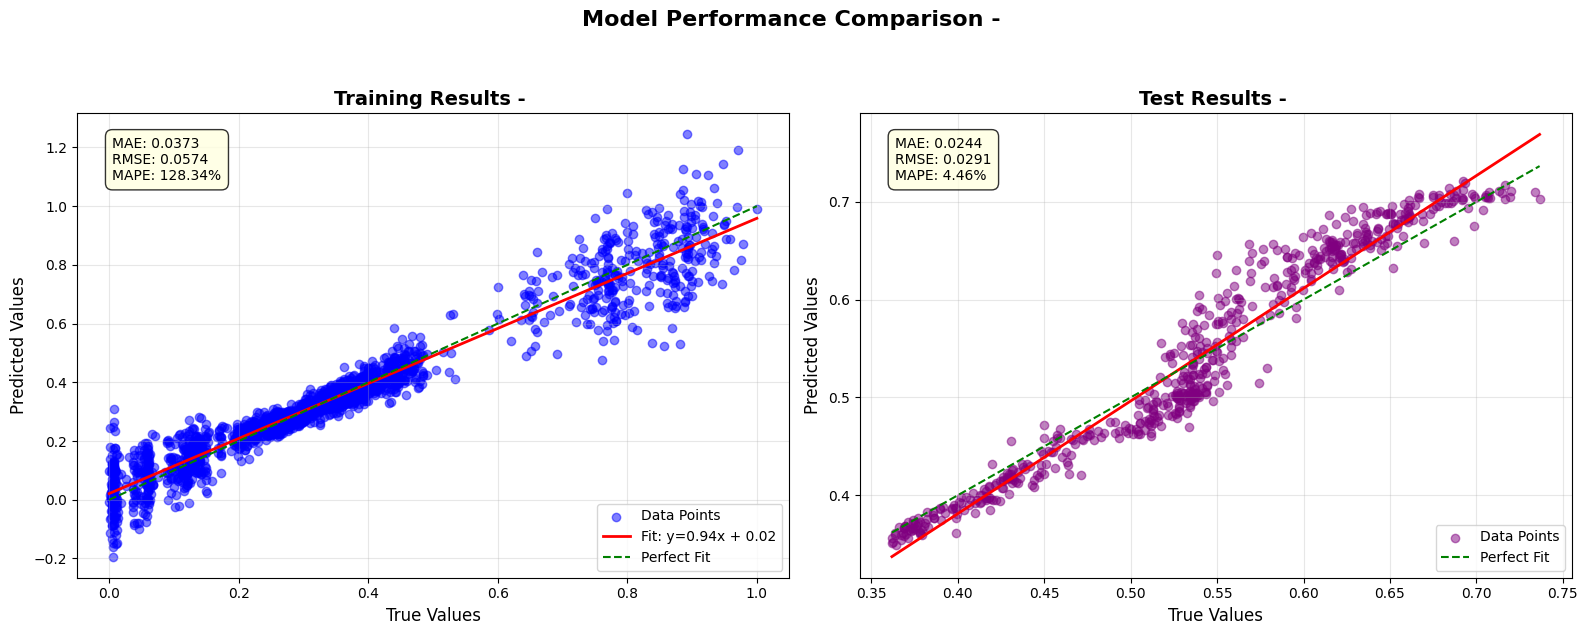

Train-test comparison plot saved as images\_train_test_comparison.png

Calculating final metrics...
Technical correlations saved to results\_technical_correlations.csv
Metrics saved to results\_metrics.txt

Final Model Performance:

Training Metrics:
MAE: 0.0373
RMSE: 0.0574
MAPE: 128.34%

Validation Metrics:
MAE: 0.0244
RMSE: 0.0291
MAPE: 4.46%

Saving model components...
Model and scaler saved for symbol: 
Features list saved at model_components/_features.pkl
Historical data saved at model_components/_historical.npy
Last sequence saved at model_components/_last_sequence.npy
Model components saved successfully.

Predicting future prices...


C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X


Creating prediction visualization...
Plot saved as _price_prediction.png


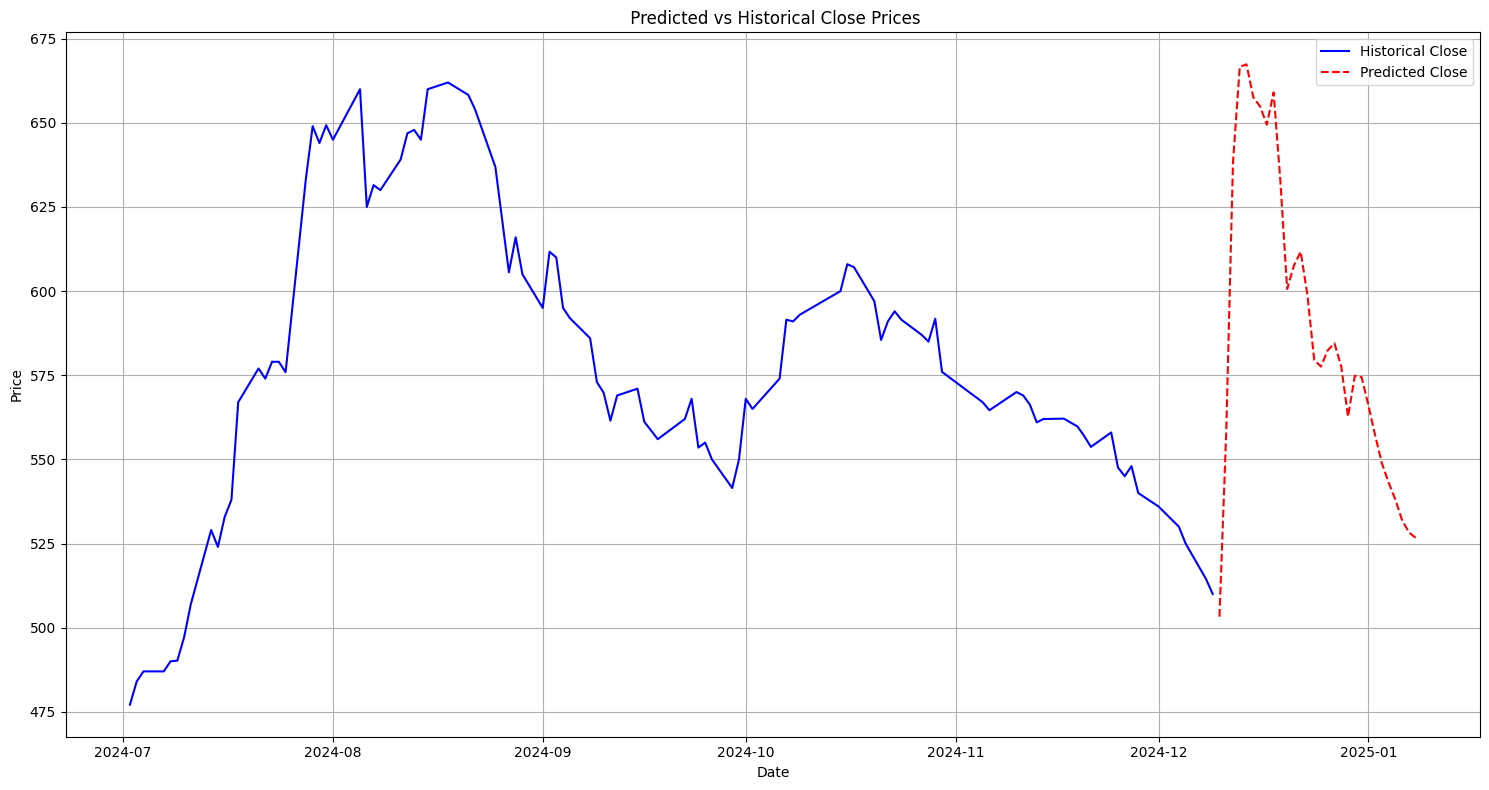

Predictions saved to results\_predictions.csv

Process completed successfully!

Creating enhanced stock comparison visualization...
Plot saved as images\_price_comparison.png


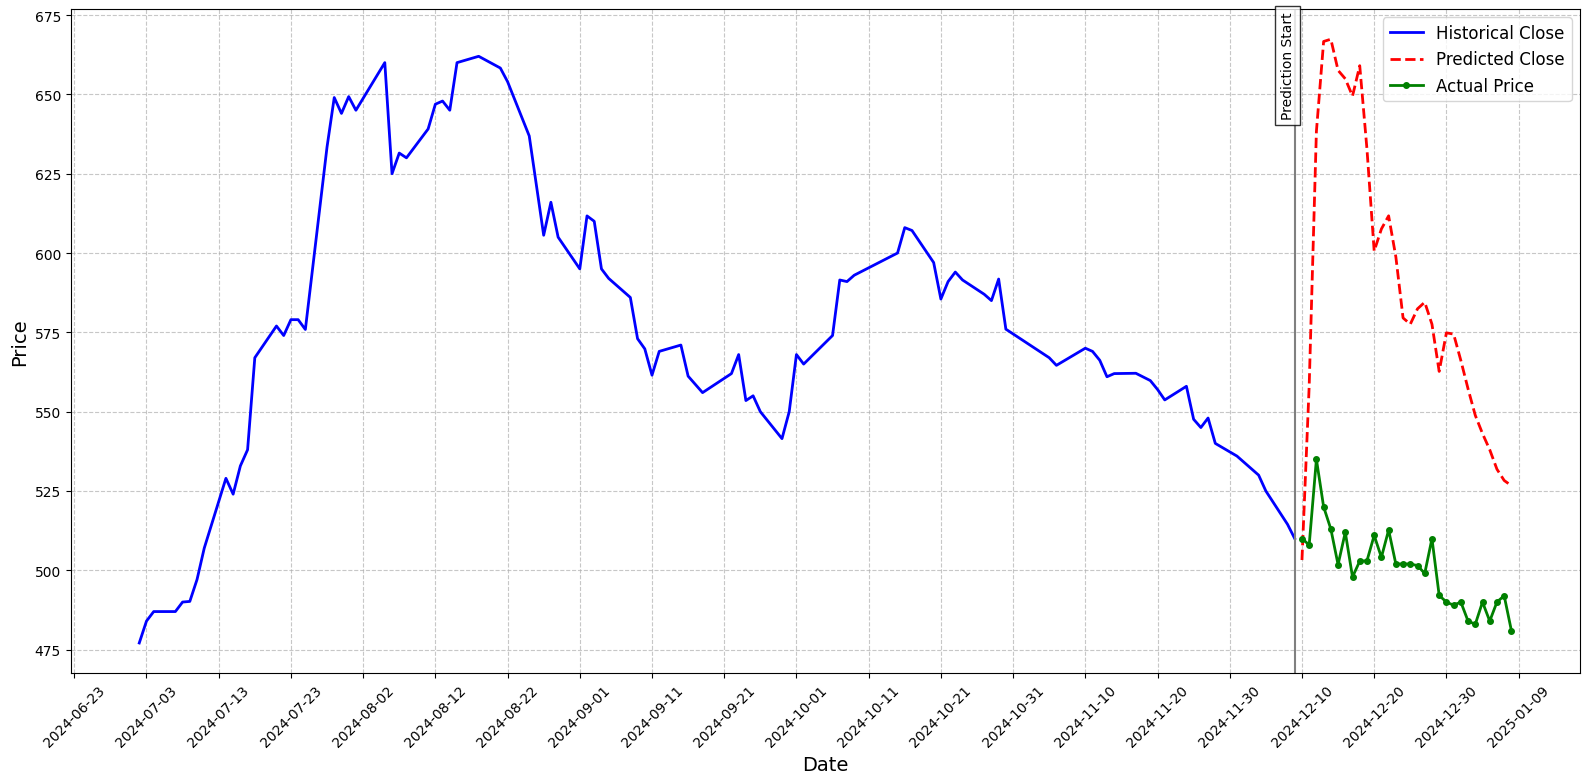

In [85]:
if __name__ == "__main__":
    # Example usage:
    price_csv =  r"C:\Users\ASUS\Desktop\SS\Model\For Students IOE\Merolagani Nepse Data\ALL STOCK CHARTS\Commercial Banks\NABIL.csv"
    news_csv = r"C:\Users\ASUS\Desktop\stocksage\combined_sentiment_df_NABIL.csv"
    stock_symbol = ""
    
    # Run the main function    
    predictions = main(price_csv, news_csv, stock_symbol)

    

In [86]:
print(len(predictions))

30
